<a href="https://colab.research.google.com/github/ZainabIftikhar1204/AHA-Moment-Finder/blob/master/DVLM_Assg0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I hope to God this works because i literally have no other option but to get through this monstrosity

# TASK 1: Inner Workings of ResNet-152

In [2]:
## PART 1 LETS GOOOO

In [3]:
!pip install torch_xla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 21.8 MB/s eta 0:00:00


In [68]:
import torchvision as tv
import torch
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet152, ResNet152_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import types
import copy
from sklearn.manifold import TSNE


# import torch
# import torch_xla
# import torch_xla.core.xla_model as xm



In [5]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = xm.xla_device()
print(f"Using Device: {DEVICE}")

Using Device: cuda


In [97]:
# default_res_net = resnet152(weights=ResNet152_Weights.DEFAULT)
default_res_net = resnet152(pretrained=True)


num_of_classes = 10

# input features for resnet 152 final layer
in_features_def = default_res_net.fc.in_features

# replace final layer with custom num of clasees
default_res_net.fc = torch.nn.Linear(in_features=in_features_def, out_features=num_of_classes)

# freeze all layers except last
for name, param in default_res_net.named_parameters():
  if 'fc' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Only the final layer parameters will be updated during training
trainable_params = sum(p.numel() for p in default_res_net.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in default_res_net.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable parameters: 20,490
Total parameters: 58,164,298


In [98]:
## hook definition
## Task 1 (3a)
features = {}

def get_features(layer_name):
  def features_hook(model, input, output):
    features[layer_name] = output.detach().cpu()
  return features_hook

In [99]:
default_res_net.conv1.register_forward_hook(get_features('early'))

default_res_net.layer3.register_forward_hook(get_features('middle'))

default_res_net.layer4.register_forward_hook(get_features('late'))


In [7]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # per channel mean and std for imageNet
        std=[0.229, 0.224, 0.225]
    )
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Load Dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=val_transform)

# Create Split
train_size = 45000
val_size = 5000

train_set, validation_set = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,          # shuffle training data
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,         # NO shuffle for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,          # shuffle test data
    num_workers=2,
    pin_memory=True
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Print split sizes
print("Train size:", len(train_set))
print("Validation size:", len(validation_set))
print("Test size:", len(test_dataset))

100%|██████████| 170M/170M [00:06<00:00, 25.3MB/s]


Train size: 45000
Validation size: 5000
Test size: 50000


In [100]:
default_res_net = default_res_net.to(DEVICE)

# loss fn and optimizer
criterion = torch.nn.CrossEntropyLoss() # for classification
optimizer = optim.Adam(default_res_net.parameters(), lr=0.001)


In [9]:
def train_epoch(model, dataloader, opitmizer, criterion, data_size):
  model.train()

  # train_data_size = len(train_dataset)

  running_loss = 0.0
  running_accuracy = 0.0

  for images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      loss.backward() #calculating gradients
      optimizer.step() #updating weights

    running_loss += loss.item() * images.size(0)
    running_accuracy += torch.sum(preds == labels.data)

  epoch_loss = running_loss / data_size
  epoch_accuracy = running_accuracy.double() * 100 / data_size

  return epoch_loss, epoch_accuracy

In [10]:
def evaluate(model, dataloader, opitmizer, criterion, data_size):
  model.eval()

  running_loss = 0.0
  running_accuracy = 0.0

  for images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_accuracy += torch.sum(preds == labels.data)

  epoch_loss = running_loss / data_size
  epoch_accuracy = running_accuracy.double() * 100 / data_size

  return epoch_loss, epoch_accuracy

In [22]:
def get_evaluattion_metrics(model):
  # TODO: Training Loop
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  #define epochs num
  num_epochs = 5

  ## data sizes
  train_data_size = len(train_dataset)
  val_data_size = len(validation_set)

  for epoch in range(num_epochs):

      train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, train_data_size)
      val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion, val_data_size)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_accs.append(train_acc)
      val_accs.append(val_acc)

      print(f"Epoch [{epoch+1}/{num_epochs}]")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
      print("-" * 50)

  return train_losses, val_losses, train_accs, val_accs


In [101]:
default_train_loss, default_val_losses, default_train_accs, default_val_accs = get_evaluattion_metrics(default_res_net)

Epoch [1/5]
  Train Loss: 0.6218 | Train Acc: 69.98%
  Val   Loss: 0.5004 | Val   Acc: 82.76%
--------------------------------------------------
Epoch [2/5]
  Train Loss: 0.4605 | Train Acc: 74.35%
  Val   Loss: 0.5148 | Val   Acc: 82.16%
--------------------------------------------------
Epoch [3/5]
  Train Loss: 0.4352 | Train Acc: 75.07%
  Val   Loss: 0.4676 | Val   Acc: 83.86%
--------------------------------------------------
Epoch [4/5]
  Train Loss: 0.4255 | Train Acc: 75.50%
  Val   Loss: 0.4279 | Val   Acc: 85.26%
--------------------------------------------------
Epoch [5/5]
  Train Loss: 0.4139 | Train Acc: 75.65%
  Val   Loss: 0.4334 | Val   Acc: 85.02%
--------------------------------------------------


**Why is it unnecessary (and impractical) to train ResNet-152 from scratch on small datasets? What does
freezing most of the network tell us about the transferability of features?**

ResNet-152 is a huge model with millions of parameters. If we try to train it using a small dataset like CIFAR-10, it will face a variety of issues:

1. A LOT of compute powere, time and resources will be needed to train it from scratch
2. Will need to tune hyperparamters accroding to each new dataset
3. even if 1 and 2 are somehow possible, the data is still very small compared to image net so the model will overfit on the data

Freezing all of the layers except the last one (i.e. classification layer) allows us to make use of the features already learned by the ResNet from ImageNet and use them to solve our problem of classifying cifar-10 images. This way, we dont need to train the model from scratch for it to be able to help in classification, we utilize existing features, saving time, resources and effort. Phew!

### 2. Residual Connections in Practice

#### a)  Disable skip connections in a few selected residual blocks and re-train the modified network head

In [12]:
## First time doing this, lets see what happenss

In [47]:
def disable_skip_conn(self, x):
  identity = x
  # if self.downsample is not None:
  #   identity = self.downsample(x)

  output = self.conv1(x) #conv
  output = self.bn1(output) #normalization
  output = self.relu(output) # relu

  output = self.conv2(output) #conv
  output = self.bn2(output) #normalization
  output = self.relu(output) # relu

  output = self.conv3(output) #conv
  output = self.bn3(output) #normalization
  output = self.relu(output) # relu

  #usually initial input is added to output at this point for skip connections
  #avoiding atm
  return output



In [37]:
disable_skip_res_net = copy.deepcopy(default_res_net) #making copy of resnet we modified for task1 (cifar)

In [48]:
# disabling last 2 blocks of layer 3 to see what happens

disable_skip_res_net.layer3[-1].forward = types.MethodType(disable_skip_conn, disable_skip_res_net.layer3[-1])
disable_skip_res_net.layer3[-2].forward = types.MethodType(disable_skip_conn, disable_skip_res_net.layer3[-2])


In [49]:
disable_train_loss, disable_val_losses, disable_train_accs, disable_val_accs = get_evaluattion_metrics(disable_skip_res_net)

Epoch [1/5]
  Train Loss: 3.0408 | Train Acc: 10.42%
  Val   Loss: 3.4127 | Val   Acc: 11.30%
--------------------------------------------------
Epoch [2/5]
  Train Loss: 3.0276 | Train Acc: 10.50%
  Val   Loss: 3.3771 | Val   Acc: 11.88%
--------------------------------------------------
Epoch [3/5]
  Train Loss: 3.0365 | Train Acc: 10.66%
  Val   Loss: 3.3937 | Val   Acc: 11.38%
--------------------------------------------------
Epoch [4/5]
  Train Loss: 3.0355 | Train Acc: 10.46%
  Val   Loss: 3.3519 | Val   Acc: 11.92%
--------------------------------------------------
Epoch [5/5]
  Train Loss: 3.0238 | Train Acc: 10.58%
  Val   Loss: 3.3787 | Val   Acc: 12.74%
--------------------------------------------------


In [55]:
disable_train_accs

[tensor(10.4220, device='cuda:0', dtype=torch.float64),
 tensor(10.5020, device='cuda:0', dtype=torch.float64),
 tensor(10.6600, device='cuda:0', dtype=torch.float64),
 tensor(10.4560, device='cuda:0', dtype=torch.float64),
 tensor(10.5800, device='cuda:0', dtype=torch.float64)]

In [58]:
disable_val_losses

[3.4127070068359373,
 3.3771448081970217,
 3.393720511627197,
 3.3518506229400633,
 3.378710007095337]

oof the accuracy fell harddd

#### b) Compare training dynamics and validation accuracy with the baseline.

In [ ]:
## comparison

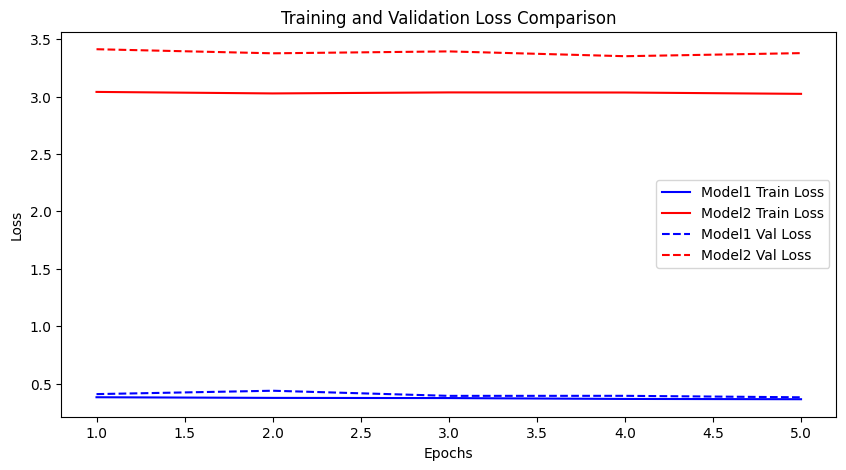

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
epochs = range(1, len(default_val_accs)+1)

# Train Loss
plt.plot(epochs, default_train_loss, 'b-', label='Model1 Train Loss')
plt.plot(epochs, disable_train_loss, 'r-', label='Model2 Train Loss')

# Val Loss
plt.plot(epochs, default_val_losses, 'b--', label='Model1 Val Loss')
plt.plot(epochs, disable_val_losses, 'r--', label='Model2 Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()


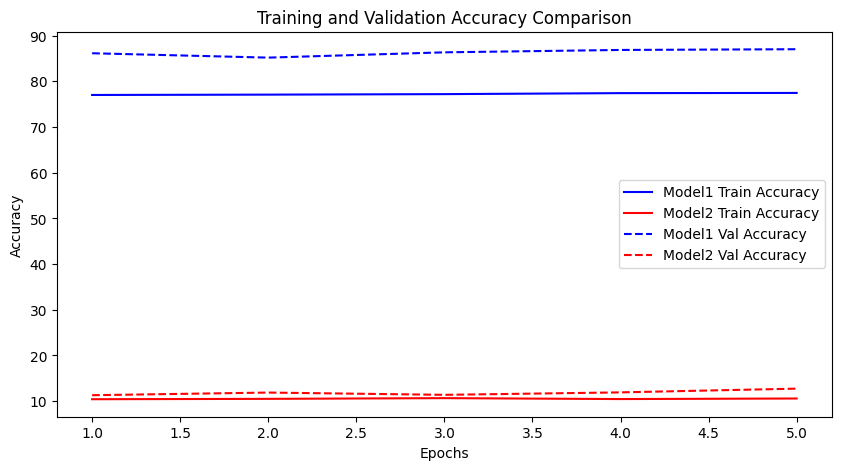

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
epochs = range(1, len(default_val_accs)+1)

#converting tensors to simple lists
default_train_accs = [x.item() for x in default_train_accs]
disable_train_accs = [x.item() for x in disable_train_accs]
default_val_accs = [x.item() for x in default_val_accs]
disable_val_accs = [x.item() for x in disable_val_accs]


# Train Accuracy
plt.plot(epochs, default_train_accs, 'b-', label='Model1 Train Accuracy')
plt.plot(epochs, disable_train_accs, 'r-', label='Model2 Train Accuracy')

# Val Accuracy
plt.plot(epochs, default_val_accs, 'b--', label='Model1 Val Accuracy')
plt.plot(epochs, disable_val_accs, 'r--', label='Model2 Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()



**How do skip connections change gradient flow in very deep networks? What happens to convergence speed
and performance when residuals are removed**

Skip connections essentially provide another route for the gradients to flow back through the network. In case of normal deep networks, when number of layers increase, the gradients either become really large (causing exponential gradients) or really small (causing vanishing gradient problem). When we provide another way for gradients to flow through in case of skip connections, it prevents the gradients from exploding or becoming 0. This way all layers can have an effect during training instead of early layers having little to no effect (in case of normal deep nets).

As far as convergence speed and performance is concerned, residual networks converge faster. They also achieve lower training error and higher accuracy than normal networks of the same depth as we have observed from the comparisons done above.

### 3. Feature Hierarchies and Representations

#### a) Collect features from early, middle, and late layers of the network.

In [66]:
# forward pass
input = torch.randn(1, 3, 224, 224).to(DEVICE)

with torch.no_grad():  # to save memory
    _ = default_res_net(input)

In [67]:
early_features  = features['early']
middle_features = features['middle']
late_features   = features['late']

print(early_features.shape, middle_features.shape, late_features.shape)

torch.Size([1, 64, 112, 112]) torch.Size([1, 1024, 14, 14]) torch.Size([1, 2048, 7, 7])


#### b) Visualize these features using dimensionality reduction (t-SNE or UMAP)

In [79]:
from sklearn.decomposition import PCA


In [82]:
flatten = torch.nn.Flatten(start_dim=1)  # output = (batch, Channels*Height*Width)

flat_early_features = flatten(early_features).cpu()
flat_middle_features = flatten(middle_features).cpu()
flat_late_features = flatten(late_features).cpu()


In [87]:
flat_early_features

tensor([[ 2.7028e-07, -1.7630e-06,  1.7082e-06,  ...,  2.1285e-02,
          1.5112e+00, -1.3858e+00]])

In [95]:
tsne = TSNE(n_components=2, learning_rate='auto',
            perplexity=float(min(30, len(flat_early_features)-1)),
            init='random', random_state=42) #random state cause results will vary otherwise

In [96]:
early_2d = tsne.fit_transform(flat_early_features)


InvalidParameterError: The 'perplexity' parameter of TSNE must be a float in the range (0.0, inf). Got 0.0 instead.